In [3]:
# # 04_stats.ipynb
# **Goal:** Perform statistical hypothesis testing on cleaned Amazon sales data:
# - Test whether festive months (Nov–Dec) show higher sales (order-level and monthly aggregates).
# - Compare Average Order Value (AOV) across product categories (ANOVA / Kruskal-Wallis).
# - Check assumptions, compute effect sizes, run post-hoc tests, and save results/plots.

# **Instructions:** Run cells in order. Inspect printed outputs and saved files in `reports/` and `data/processed/`.


In [5]:
# Imports & small config
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Create needed folders
os.makedirs("../reports/images", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

# Settings
ALPHA = 0.05  # significance level
plt.rcParams.update({"figure.figsize": (10,5), "font.size": 11})
sns.set_style("whitegrid")


In [6]:
clean_path = "../data/processed/Amazon_Sales_Cleaned.csv"
if not os.path.exists(clean_path):
    raise FileNotFoundError(f"Cleaned dataset not found at {clean_path}. Run cleaning notebook first.")

df = pd.read_csv(clean_path, parse_dates=['Date'], low_memory=False)
print("Loaded:", clean_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure required revenue column exists
if 'Total_Amount' not in df.columns:
    # Fallback: attempt to create from Amount column
    if 'Amount' in df.columns:
        df['Total_Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    else:
        raise KeyError("No 'Total_Amount' or 'Amount' column found. Check cleaned dataset.")

# Basic date range
print("Date range:", df['Date'].min(), "to", df['Date'].max())


Loaded: ../data/processed/Amazon_Sales_Cleaned.csv
Shape: (116269, 30)
Columns: ['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Amount_raw', 'Total_Amount', 'Unit_Price', 'Year', 'Month', 'Day', 'Month_Year', 'Order_MonthStart']
Date range: 2022-03-31 00:00:00 to 2022-06-29 00:00:00


In [7]:
# Festive months: Nov (11) and Dec (12)
df['Month'] = df['Date'].dt.month
df['is_festive'] = df['Month'].isin([11,12])

# Monthly aggregated totals (for time-series level test)
monthly = df.resample('M', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')
monthly['MonthNum'] = monthly['Date'].dt.month
monthly['is_festive'] = monthly['MonthNum'].isin([11,12])

print("Per-order rows:", df.shape[0], "Monthly periods:", monthly.shape[0])


Per-order rows: 116269 Monthly periods: 4


C:\Users\Utkarsh Pal\AppData\Local\Temp\ipykernel_28204\958981158.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M', on='Date')['Total_Amount'].sum().reset_index().sort_values('Date')


In [9]:
# Extract series
festive_orders = df[df['is_festive']]['Total_Amount'].dropna()
nonfestive_orders = df[~df['is_festive']]['Total_Amount'].dropna()

print("Per-order counts -> Festive:", festive_orders.shape[0], "Non-festive:", nonfestive_orders.shape[0])

# Basic descriptives
desc = {
    "festive_mean": festive_orders.mean(),
    "festive_median": festive_orders.median(),
    "festive_std": festive_orders.std(),
    "nonfestive_mean": nonfestive_orders.mean(),
    "nonfestive_median": nonfestive_orders.median(),
    "nonfestive_std": nonfestive_orders.std()
}
print(pd.Series(desc).to_string())

# Welch's t-test (does not assume equal variances)
tstat, pval = stats.ttest_ind(festive_orders, nonfestive_orders, equal_var=False)
print(f"\nWelch t-test: t = {tstat:.4f}, p-value = {pval:.4e}")

# Cohen's d (pooled sd)
n1, n2 = len(festive_orders), len(nonfestive_orders)
s1, s2 = festive_orders.std(ddof=1), nonfestive_orders.std(ddof=1)
# pooled sd (for interpretation; Welch uses unequal var but Cohen's d often uses pooled)
pooled_sd = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2))
cohens_d = (festive_orders.mean() - nonfestive_orders.mean()) / pooled_sd if pooled_sd > 0 else np.nan
print(f"Cohen's d (pooled): {cohens_d:.3f}")

# Conclusion
if pval < ALPHA:
    print("Result: Reject H0 — festive orders have different mean Total_Amount (p < 0.05).")
else:
    print("Result: Fail to reject H0 — no significant difference found at alpha=0.05.")


Per-order counts -> Festive: 0 Non-festive: 116041
festive_mean                NaN
festive_median              NaN
festive_std                 NaN
nonfestive_mean      649.769228
nonfestive_median    606.000000
nonfestive_std       282.636211

Welch t-test: t = nan, p-value = nan
Cohen's d (pooled): nan
Result: Fail to reject H0 — no significant difference found at alpha=0.05.


C:\Users\Utkarsh Pal\AppData\Roaming\Python\Python313\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


C:\Users\Utkarsh Pal\AppData\Local\Temp\ipykernel_28204\3097591131.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['Non-Festive','Festive'])
C:\Users\Utkarsh Pal\AppData\Local\Temp\ipykernel_28204\3097591131.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['Non-Festive','Festive'])


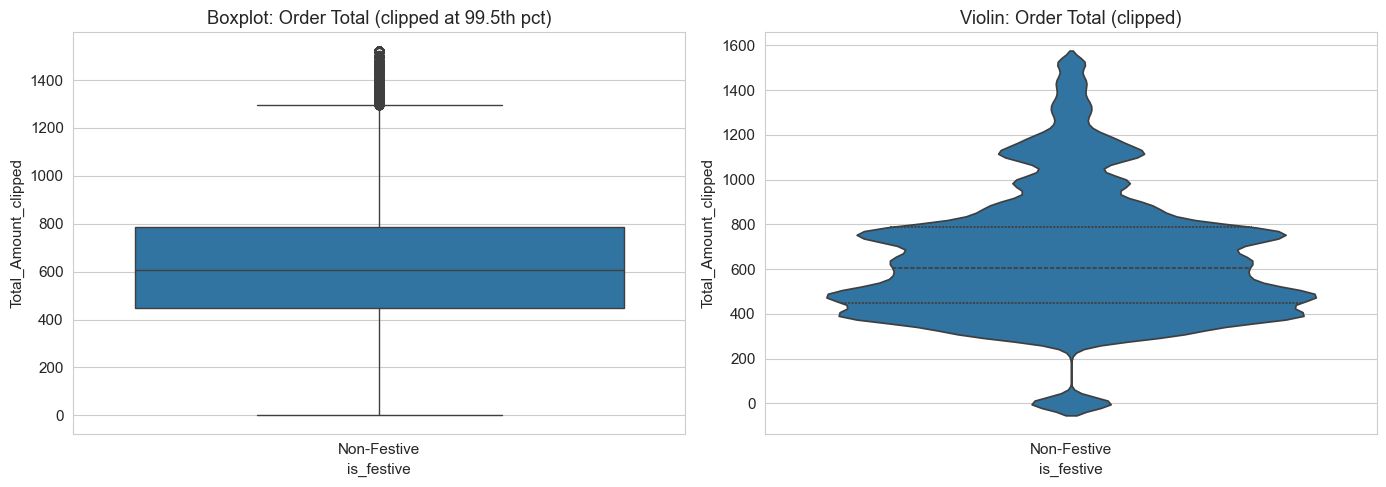

In [10]:
# To reduce plotting skew, cap extremes for visualization (but not for tests)
cap = df['Total_Amount'].quantile(0.995)
plot_df = df.copy()
plot_df['Total_Amount_clipped'] = np.where(plot_df['Total_Amount']>cap, cap, plot_df['Total_Amount'])

fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='is_festive', y='Total_Amount_clipped', data=plot_df, ax=ax[0])
ax[0].set_xticklabels(['Non-Festive','Festive'])
ax[0].set_title('Boxplot: Order Total (clipped at 99.5th pct)')

sns.violinplot(x='is_festive', y='Total_Amount_clipped', data=plot_df, ax=ax[1], inner='quartile')
ax[1].set_xticklabels(['Non-Festive','Festive'])
ax[1].set_title('Violin: Order Total (clipped)')

plt.tight_layout()
plt.savefig("../reports/images/festive_vs_nonfestive_order_dist.png", dpi=150)
plt.show()


Monthly periods -> Festive: 0 Non-festive: 4
Monthly means -> Festive: nan Non-festive: 18849967.75
Monthly-level Welch t-test: t = nan, p-value = nan


C:\Users\Utkarsh Pal\AppData\Roaming\Python\Python313\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


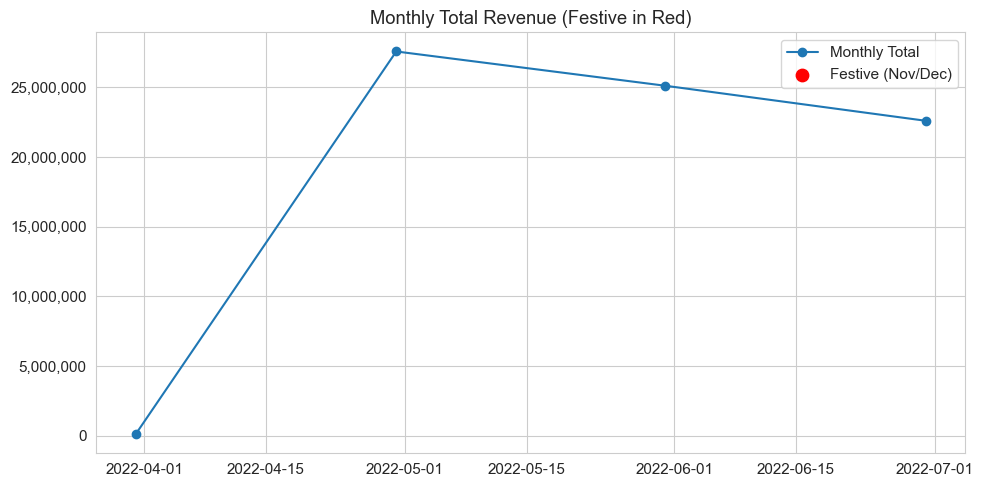

Monthly-level: Fail to reject H0 — no significant difference in monthly totals at alpha=0.05.


In [11]:
# Create two groups of monthly totals: festive months vs other months (across all years)
festive_monthly = monthly[monthly['is_festive']]['Total_Amount'].dropna()
nonfestive_monthly = monthly[~monthly['is_festive']]['Total_Amount'].dropna()

print("Monthly periods -> Festive:", festive_monthly.shape[0], "Non-festive:", nonfestive_monthly.shape[0])
print("Monthly means -> Festive:", festive_monthly.mean(), "Non-festive:", nonfestive_monthly.mean())

# Small sample sizes at monthly level — use Welch t-test
t_m, p_m = stats.ttest_ind(festive_monthly, nonfestive_monthly, equal_var=False)
print(f"Monthly-level Welch t-test: t = {t_m:.4f}, p-value = {p_m:.4e}")

# Plot monthly totals with festive markers
fig, ax = plt.subplots()
ax.plot(monthly['Date'], monthly['Total_Amount'], marker='o', label='Monthly Total')
ax.scatter(monthly[monthly['is_festive']]['Date'], monthly[monthly['is_festive']]['Total_Amount'], color='red', s=80, label='Festive (Nov/Dec)')
ax.set_title('Monthly Total Revenue (Festive in Red)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f"{int(x):,}"))
ax.legend()
plt.tight_layout()
plt.savefig("../reports/images/monthly_festive_vs_nonfestive.png", dpi=150)
plt.show()

if p_m < ALPHA:
    print("Monthly-level: Reject H0 — festive months show different mean monthly totals (p < 0.05).")
else:
    print("Monthly-level: Fail to reject H0 — no significant difference in monthly totals at alpha=0.05.")


In [12]:
# Ensure Category exists and clean categories with very few observations
if 'Category' not in df.columns:
    print("No 'Category' column found. Skipping ANOVA.")
else:
    # Consider categories with minimum sample size to be meaningful (e.g., >= 50 orders)
    counts = df['Category'].value_counts()
    min_n = 40
    valid_cats = counts[counts >= min_n].index.tolist()
    print(f"Categories considered (n>={min_n}): {len(valid_cats)} categories")

    anova_df = df[df['Category'].isin(valid_cats)].copy()
    # Prepare groups
    groups = [group['Total_Amount'].values for name, group in anova_df.groupby('Category')]

    # Levene test for equal variances
    levene_stat, levene_p = stats.levene(*groups, center='median')
    print(f"Levene test: stat={levene_stat:.4f}, p={levene_p:.4e} (p<{ALPHA} indicates unequal variances)")

    # One-way ANOVA (if groups not too unbalanced)
    f_stat, p_anova = stats.f_oneway(*groups)
    print(f"ANOVA: F={f_stat:.4f}, p={p_anova:.4e}")

    # If ANOVA significant, do Tukey HSD (post-hoc)
    if p_anova < ALPHA:
        print("ANOVA significant — performing Tukey HSD post-hoc test.")
        # Prepare data for Tukey: arrays of measurement + labels
        tukey_data = anova_df[['Total_Amount', 'Category']].dropna()
        tukey = pairwise_tukeyhsd(endog=tukey_data['Total_Amount'], groups=tukey_data['Category'], alpha=ALPHA)
        print(tukey.summary())
        # Save tukey table to CSV
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukey_df.to_csv("../reports/tukey_hsd_results.csv", index=False)
        print("Saved Tukey HSD results to ../reports/tukey_hsd_results.csv")
    else:
        print("ANOVA not significant. Considering Kruskal-Wallis (non-parametric) if assumptions fail.")
        # Kruskal-Wallis
        kw_stat, kw_p = stats.kruskal(*groups)
        print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4e}")
        if kw_p < ALPHA:
            print("Kruskal-Wallis significant — categories differ (non-parametric).")
        else:
            print("No significant difference across categories by Kruskal-Wallis either.")


Categories considered (n>=40): 8 categories
Levene test: stat=nan, p=nan (p<0.05 indicates unequal variances)
ANOVA: F=nan, p=nan
ANOVA not significant. Considering Kruskal-Wallis (non-parametric) if assumptions fail.
Kruskal-Wallis: H=nan, p=nan
No significant difference across categories by Kruskal-Wallis either.


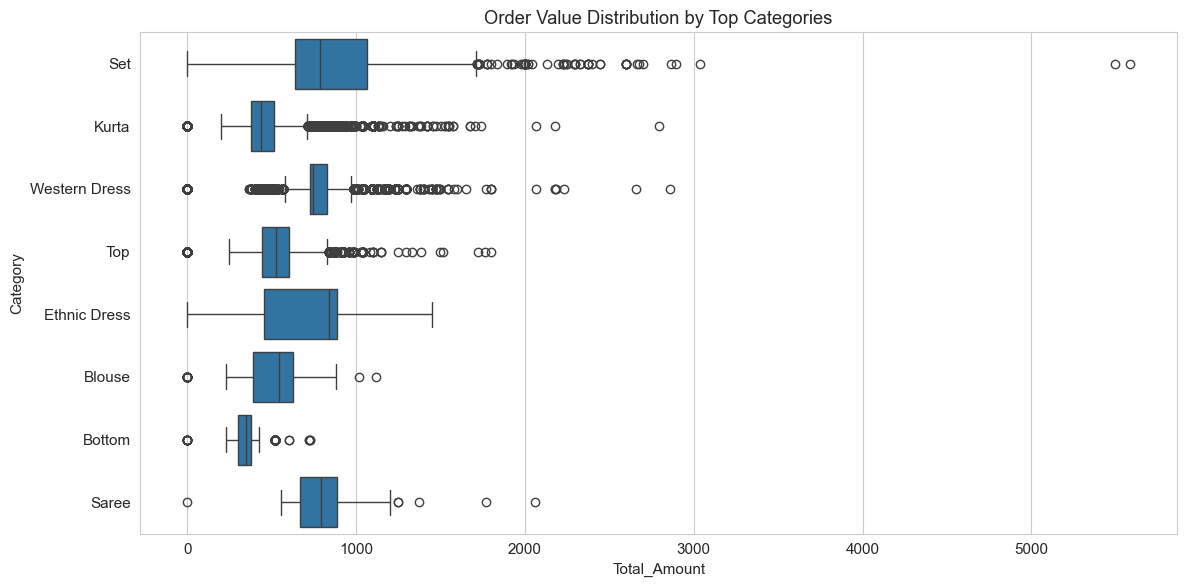

In [13]:
if 'Category' in df.columns and len(valid_cats) > 0:
    top_cats = valid_cats[:10]  # top 10 categories by count considered
    viz_df = df[df['Category'].isin(top_cats)].copy()
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Total_Amount', y='Category', data=viz_df, order=top_cats)
    plt.title("Order Value Distribution by Top Categories")
    plt.xlabel("Total_Amount")
    plt.tight_layout()
    plt.savefig("../reports/images/aov_by_category_boxplot.png", dpi=150)
    plt.show()
else:
    print("Skipping AOV boxplot — no valid categories found.")


In [15]:
results = {
    "per_order": {
        "festive_count": int(festive_orders.shape[0]),
        "nonfestive_count": int(nonfestive_orders.shape[0]),
        "festive_mean": float(festive_orders.mean()),
        "nonfestive_mean": float(nonfestive_orders.mean()),
        "t_stat": float(tstat),
        "p_value": float(pval),
        "cohens_d": float(cohens_d)
    },
    "monthly": {
        "festive_months_count": int(festive_monthly.shape[0]),
        "nonfestive_months_count": int(nonfestive_monthly.shape[0]),
        "festive_month_mean": float(festive_monthly.mean() if len(festive_monthly)>0 else np.nan),
        "nonfestive_month_mean": float(nonfestive_monthly.mean() if len(nonfestive_monthly)>0 else np.nan),
        "t_stat": float(t_m),
        "p_value": float(p_m)
    },
    "anova": {
        "categories_considered": valid_cats if 'valid_cats' in locals() else [],
        "anova_p_value": float(p_anova) if 'p_anova' in locals() else None,
        "levene_p_value": float(levene_p) if 'levene_p' in locals() else None
    }
}

# Save results to JSON and CSV summary
with open("../reports/statistics_results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved statistical results to ../reports/statistics_results.json")

# Also write a short text summary for quick viewing
summary_lines = [
    f"Per-order Welch t-test: t={tstat:.4f}, p={pval:.4e}, Cohen's d={cohens_d:.3f}",
    f"Monthly Welch t-test: t={t_m:.4f}, p={p_m:.4e}",
    f"ANOVA p-value (categories): {p_anova:.4e}" if 'p_anova' in locals() else "ANOVA not run",
]
with open("../reports/stats_summary.txt", "w") as f:
    f.write("\n".join(summary_lines))
print("Saved human-readable summary to ../reports/stats_summary.txt")
print("\nSummary:\n", "\n".join(summary_lines))


Saved statistical results to ../reports/statistics_results.json
Saved human-readable summary to ../reports/stats_summary.txt

Summary:
 Per-order Welch t-test: t=nan, p=nan, Cohen's d=nan
Monthly Welch t-test: t=nan, p=nan
ANOVA p-value (categories): nan


In [18]:
# # Statistical Findings — quick interpretation (template)

# - Per-order test (festive vs non-festive): 
#   - [Report the t-stat and p-value from the notebook]. 
#   - If p < 0.05, conclude: "Festive-period orders have a statistically significant different mean Total_Amount (p < 0.05)."
#   - Also report effect size (Cohen's d) to communicate practical significance.

# - Monthly-aggregated test:
#   - [Report monthly-level test]. This compares monthly totals for Nov/Dec vs other months across the sample period. 
#   - If p < 0.05, conclude: "Festive months have significantly different monthly revenue."

# - Category AOV test:
#   - If ANOVA significant, use Tukey HSD results (`../reports/tukey_hsd_results.csv`) to see which category pairs differ.
#   - If ANOVA not suitable (violated assumptions), use Kruskal-Wallis result.

# **Notes & cautions:**
# - Per-order tests ignore temporal autocorrelation; monthly-aggregated tests handle seasonality better but have fewer samples.
# - Large sample sizes can make small differences statistically significant — always report effect sizes and practical interpretation.
